# classic mean-variance portfolio optimization

Assume we have n assets and their expected return column vector is <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x3BC;</mi>
</math>
 and their covariance matrix is <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x3A3;</mi>
</math>.

In [7]:
pip install yfinance

     |████████████████████████████████| 123 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 10.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 173 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.7 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 41.4 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 13.2 MB/s eta 0:00:01
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
     |████████████████████████████████| 347 kB 10.3 MB/s eta 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15540 sha256=f373224b41d20d

In [78]:
import pandas as pd
import yfinance as yf

assets = ["AAPL", "MSFT", "GOOGL", "KO", "DIS", "JPM"]
data = yf.download(assets, start="2015-01-01", end="2017-12-31", auto_adjust=False)["Adj Close"]
print(data.head())

[*********************100%***********************]  6 of 6 completed

Ticker           AAPL        DIS      GOOGL        JPM         KO       MSFT
Date                                                                        
2015-01-02  24.237549  85.943520  26.296137  46.720936  29.783401  39.858467
2015-01-05  23.554737  84.687592  25.795090  45.270481  29.783401  39.491924
2015-01-06  23.556957  84.238396  25.158480  44.096653  30.009581  38.912292
2015-01-07  23.887276  85.100128  25.084490  44.163956  30.384180  39.406677
2015-01-08  24.805088  85.980186  25.171888  45.150856  30.751682  40.565952


The GMV portfolio is the portfolio of asset weights that achieves the lowest possible variance (risk) among all portfolios that are fully invested.

In [79]:
# calculate historical log returns
import numpy as np
hist_data = {}
data = yf.download(assets, start="2015-01-01", end="2017-12-31", auto_adjust=False)
hist_data = data["Adj Close"]

# computes daily log returns for all assets.
hist_return = np.log(hist_data / hist_data.shift())
hist_return

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,DIS,GOOGL,JPM,KO,MSFT
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.028576,-0.014721,-0.019238,-0.031537,0.000000,-0.009239
2015-01-06,0.000094,-0.005318,-0.024989,-0.026271,0.007565,-0.014786
2015-01-07,0.013925,0.010178,-0.002945,0.001525,0.012405,0.012625
2015-01-08,0.037703,0.010288,0.003478,0.022100,0.012023,0.028994
...,...,...,...,...,...,...
2017-12-22,0.000000,-0.008248,-0.001860,-0.003530,-0.000219,0.000117
2017-12-26,-0.025698,-0.005074,-0.002820,-0.004010,0.004814,-0.001287
2017-12-27,0.000176,-0.004449,-0.005315,0.001867,0.002616,0.003623


In [80]:
hist_return = hist_return.dropna()

# find historical mean, covriance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()
print(hist_mean.transpose())
print(hist_cov)
print(hist_corr)

Ticker      AAPL       DIS     GOOGL       JPM        KO      MSFT
mu      0.000652  0.000238  0.000912  0.000808  0.000242  0.000902
Ticker      AAPL       DIS     GOOGL       JPM        KO      MSFT
Ticker                                                            
AAPL    0.000208  0.000055  0.000086  0.000076  0.000032  0.000102
DIS     0.000055  0.000138  0.000039  0.000072  0.000030  0.000055
GOOGL   0.000086  0.000039  0.000190  0.000063  0.000035  0.000113
JPM     0.000076  0.000072  0.000063  0.000180  0.000032  0.000085
KO      0.000032  0.000030  0.000035  0.000032  0.000065  0.000043
MSFT    0.000102  0.000055  0.000113  0.000085  0.000043  0.000201
Ticker      AAPL       DIS     GOOGL       JPM        KO      MSFT
Ticker                                                            
AAPL    1.000000  0.324261  0.431857  0.390815  0.277773  0.500462
DIS     0.324261  1.000000  0.243120  0.457904  0.313573  0.332145
GOOGL   0.431857  0.243120  1.000000  0.338612  0.313404  0.58

In [81]:
# construct random portfolios
n_portfolios = 3000
#set up array to hold results
port_returns = np.zeros(n_portfolios)
port_stdevs = np.zeros(n_portfolios)

In [82]:
# returns are typically annualized assuming ~250 trading days
for i in range(n_portfolios):
    w = np.random.rand(len(assets))        # random weights
    w = w / sum(w)                         # weights sum to 1
    port_return = np.dot(w.T, hist_mean.values.flatten()) * 250        # annualize; 250 business days
    port_stdev = np.sqrt(np.dot(w.T, np.dot(hist_cov, w))) * np.sqrt(250)  # annualize; 250 business days
    port_returns[i] = port_return
    port_stdevs[i] = port_stdev

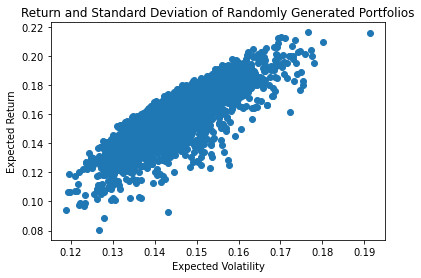

In [83]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(port_stdevs, port_returns, 'o', markersize=6)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

# Global Minimum Variance 

 Global Minimum Variance (GMV) is the far left one of all the portfolios.

$w^* = \frac{\Sigma^{-1}\mathbf{1}}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}}$

In [86]:
# Global Minimum Variance (GMV) -- closed form solution
hist_cov_inv = - np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv

array([ 0.06291736,  0.17101934,  0.09700704,  0.06894839,  0.64001232,
       -0.03990445])

In [87]:
w_gmv_df = pd.DataFrame(data = w_gmv).transpose()
w_gmv_df.columns = assets
w_gmv_df

,AAPL,MSFT,GOOGL,KO,DIS,JPM
0,0.062917,0.171019,0.097007,0.068948,0.640012,-0.039904


In [88]:
stdev_gmv = np.sqrt(np.dot(w_gmv.T, np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print(w_gmv_df)
print(stdev_gmv)

       AAPL      MSFT     GOOGL        KO       DIS       JPM
0  0.062917  0.171019  0.097007  0.068948  0.640012 -0.039904
0.1146301869538385


In [46]:
pip install cvxopt

     |████████████████████████████████| 13.8 MB 130 kB/s eta 0:00:01    |█████████▌                      | 4.1 MB 100 kB/s eta 0:01:38
Note: you may need to restart the kernel to use updated packages.


In [3]:
from cvxopt.solvers import qp
from cvxopt import matrix

In [89]:
# Global Minimum Variance (GMV) -- numerical method Python quadratic solver cvxopt
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(1.0, (1, len(assets)))
b = matrix(1.0)

In [90]:
P

<6x6 matrix, tc='d'>

In [91]:
w_gmv_v2 = np.array(qp(P, q, A=A, b=b)['x'])
w_gmv_v2

array([[ 0.06291736],
       [ 0.17101934],
       [ 0.09700704],
       [ 0.06894839],
       [ 0.64001232],
       [-0.03990445]])

## Efficient Portfolio

primary problem: finds highest return given a certain risk level
\begin{matrix}
\max & \mu_p=w^T\mu \\\\
s.t. & \sigma_p^2=w^T\Sigma w\\
     & w^T\mathbf{1}=1
\end{matrix}      

dual problem: finds the minimum risk given a certain return level 
\begin{matrix}
\min & \sigma_p^2=w^T\Sigma w \\\\
s.t. & \mu_p=w^T\mu=\mu_{o} \\\\
     & w^T\mathbf{1} = 1
\end{matrix}                

In [92]:
# Maximum return -- closed form solution
mu_o = np.max(hist_mean).item()   # MCD, given return level

\begin{matrix}
\lambda &=&\begin{pmatrix}\lambda_1 \\\\ \lambda_2 \end{pmatrix}=-2A^{-1}y  \\\\
A &=& \begin{pmatrix} \mu^T\Sigma^{-1}\mu & \mu^T\Sigma^{-1}\mathbf{1} \\\\ \mu^T\Sigma^{-1}\mathbf{1} & \mathbf{1}^T\Sigma^{-1}\mathbf{1} \end{pmatrix} \\\\
y &=& \begin{pmatrix}\mu_o \\\\ 1\end{pmatrix}
\end{matrix}

\begin{matrix}
w^*&=&-\frac{1}{2}\Sigma^{-1}B\lambda=\Sigma^{-1}BA^{-1}y \\\\
B&=&[\mu;\mathbf{1}]
\end{matrix}

In [93]:
A = np.matrix([[np.dot(hist_mean.T,np.dot(hist_cov_inv,hist_mean)).item(),
                np.dot(hist_mean.T,np.dot(hist_cov_inv,one_vec)).item()],
               [np.dot(hist_mean.T,np.dot(hist_cov_inv,one_vec)).item(),
                np.dot(one_vec.T,np.dot(hist_cov_inv,one_vec)).item()]])
B = np.hstack([np.array(hist_mean),one_vec.reshape(len(assets),1)])
y = np.matrix([mu_o, 1]).T
w_max_ret = np.dot(np.dot(np.dot(hist_cov_inv, B),  np.linalg.inv(A)),y)
w_max_ret_df = pd.DataFrame(w_max_ret).T
w_max_ret_df.columns = assets
print(w_max_ret_df)

       AAPL     MSFT    GOOGL       KO       DIS       JPM
0  0.054483 -0.18248  0.38767  0.41682  0.094168  0.229339


## Efficient Frontier 

In [94]:
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(np.hstack([np.array(hist_mean),one_vec.reshape(len(assets),1)]).transpose())
b = matrix([mu_o,1])

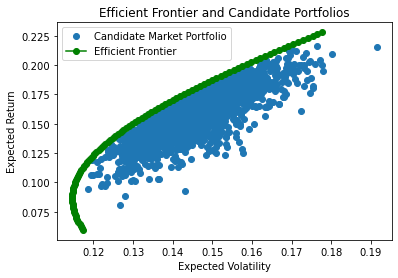

In [95]:
# efficient frontier
N = 100
ef_left = min(hist_mean.to_numpy()).item()         # minimum return
ef_right = max(hist_mean.to_numpy()).item()    # maximum return
target_returns = np.linspace(ef_left, ef_right, N)         # N target returns
optimal_weights = [qp(P, q, A=A, b=matrix([t,1]))['x'] for t in target_returns]    # QP solver
ef_returns = [np.dot(w.T, hist_mean).item() * 250 for w in optimal_weights]         #annualized
ef_risks = [np.sqrt(np.dot(w.T, np.dot(hist_cov, w)).item() * 250) for w in optimal_weights ]

import matplotlib.pyplot as plt
plt.plot(port_stdevs, port_returns, 'o', markersize=6, label='Candidate Market Portfolio')
plt.plot(ef_risks, ef_returns, 'y-o', color='green', markersize=6, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Candidate Portfolios')
plt.legend(loc='best')
plt.show()

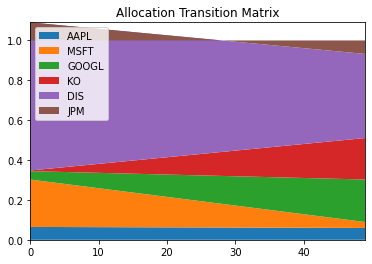

In [96]:
# visualize the weight allocation transition matrix of efficient portfolios from low returns to high returns.

transition_data = pd.DataFrame(optimal_weights)
transition_data.columns = assets
plt.stackplot(range(50), transition_data.iloc[:50,:].T, labels=assets)  
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.title('Allocation Transition Matrix')
plt.show()

In [62]:
transition_data.iloc[:50,:].T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAPL,1.002961,0.982120,0.961279,0.940437,0.919596,0.898755,0.877913,0.857072,0.836230,0.815389,...,0.169307,0.148465,0.127624,0.106782,0.085941,0.065100,0.044258,0.023417,0.002576,-0.018266
MSFT,0.071633,0.081563,0.091492,0.101421,0.111351,0.121280,0.131210,0.141139,0.151068,0.160998,...,0.468809,0.478738,0.488668,0.498597,0.508527,0.518456,0.528385,0.538315,0.548244,0.558174
GOOGL,-0.074595,-0.063683,-0.052771,-0.041859,-0.030947,-0.020035,-0.009123,0.001789,0.012701,0.023613,...,0.361884,0.372796,0.383708,0.394620,0.405532,0.416444,0.427356,0.438268,0.449180,0.460092
